<a href="https://colab.research.google.com/github/Lucs1590/study_segmentation/blob/main/instance_segmentation_train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Instance Segmentation Training

# Google Drive Connection

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


# Repo Download

In [2]:
!git clone https://github.com/matterport/Mask_RCNN

Cloning into 'Mask_RCNN'...
remote: Enumerating objects: 956, done.
remote: Total 956 (delta 0), reused 0 (delta 0), pack-reused 956
Receiving objects: 100% (956/956), 125.23 MiB | 24.63 MiB/s, done.
Resolving deltas: 100% (565/565), done.


In [3]:
!cp -R /content/Mask_RCNN/mrcnn /content/

In [4]:
!cp /content/gdrive/MyDrive/image-segmentation-course/maskrcnn/model.py /content/mrcnn/

# Libraries Import

In [5]:
import os
import sys
import random
import math
import re
import time
import numpy as np
import cv2
import matplotlib.pyplot as plt
import json
import pandas as pd

In [6]:
!pip install --upgrade h5py==2.10.0
!pip install -U scikit-image==0.16.2
import skimage.draw
from skimage.io import imread
skimage.__version__

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.9 MB 15.4 MB/s 
  Attempting uninstall: h5py
    Found existing installation: h5py 3.1.0
    Uninstalling h5py-3.1.0:
      Successfully uninstalled h5py-3.1.0
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 26.5 MB 1.3 MB/s 
  Attempting uninstall: scikit-image
    Found existing installation: scikit-image 0.18.3
    Uninstalling scikit-image-0.18.3:
      Successfully uninstalled scikit-image-0.18.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


'0.16.2'

In [7]:
%tensorflow_version 1.x
import tensorflow
tensorflow.__version__

After that, `%tensorflow_version 1.x` will throw an error.

Your notebook should be updated to use Tensorflow 2.
See the guide at https://www.tensorflow.org/guide/migrate#migrate-from-tensorflow-1x-to-tensorflow-2.

TensorFlow 1.x selected.


'1.15.2'

In [8]:
import skimage

In [9]:
from mrcnn.config import Config
import mrcnn.utils as utils
from mrcnn import visualize
import mrcnn.model as modellib
from mrcnn.model import log

Using TensorFlow backend.


In [10]:
#!pip install tensorflow==1.15.5
#!pip install tensorflow-gpu==1.15.0
#!pip install q keras==2.1.0

In [11]:
root_path = os.path.abspath('/content/Mask_RCNN')

# Dataset

## Dataset Download

In [12]:
!cp /content/gdrive/MyDrive/image-segmentation-course/datasets/balloon_dataset.zip /content/

In [13]:
!unzip balloon_dataset.zip

Archive:  balloon_dataset.zip
   creating: balloon/
   creating: balloon/train/
  inflating: balloon/train/via_region_data.json  
   creating: __MACOSX/
   creating: __MACOSX/balloon/
   creating: __MACOSX/balloon/train/
  inflating: __MACOSX/balloon/train/._via_region_data.json  
  inflating: balloon/train/53500107_d24b11b3c2_b.jpg  
  inflating: __MACOSX/balloon/train/._53500107_d24b11b3c2_b.jpg  
  inflating: balloon/train/120853323_d4788431b9_b.jpg  
  inflating: __MACOSX/balloon/train/._120853323_d4788431b9_b.jpg  
  inflating: balloon/train/126700562_8e27720147_b.jpg  
  inflating: __MACOSX/balloon/train/._126700562_8e27720147_b.jpg  
  inflating: balloon/train/145053828_e0e748717c_b.jpg  
  inflating: __MACOSX/balloon/train/._145053828_e0e748717c_b.jpg  
  inflating: balloon/train/154446334_5d41cd1375_b.jpg  
  inflating: __MACOSX/balloon/train/._154446334_5d41cd1375_b.jpg  
  inflating: balloon/train/155815494_800fc9aa32_b.jpg  
  inflating: __MACOSX/balloon/train/._155815494_8

## Dataset Loading

In [14]:
class CustomDataset(utils.Dataset):

    def load_object(self, dataset_dir, subset, nome_annotation="via_region_data.json"):
        """Carrega um subconjunto do dataset Balloon.
        dataset_dir: Diretorio raíz do dataset.
        subset: Subconjunto a ser carregado: train (treinamento) ou val (validação)
        """
        # Adiciona as classes. Nesse exemplo, temos apenas uma classe para adicionar.
        self.add_class("objetos", 1, "balloon")

        # Escolhe se é o dataset de Treinamento ou Validação 
        assert subset in ["train", "val"]
        dataset_dir = os.path.join(dataset_dir, subset)

        # Carrega as anotações (annotations) 
        # VGG Image Annotator (Até a verão 1.6) salva cada imagem no formato: 
        # { 'filename': '28503151_5b5b7ec140_b.jpg',
        #   'regions': {
        #       '0': {
        #           'region_attributes': {},
        #           'shape_attributes': {
        #               'all_points_x': [...],
        #               'all_points_y': [...],
        #               'name': 'polygon'}},
        #       ... more regions ...
        #   },
        #   'size': 100202
        # }
        # O que mais interessa para nós são as coordenadas x e y de cada região
        # Obs: No VIA 2.0, as regiões são salvas em forma de lista ao invés de dicionario.
        annotations = json.load(open(os.path.join(dataset_dir, nome_annotation)))
        annotations = list(annotations.values())  # não precisa das dict keys

        # A ferramenta VIA salva as imagens em JSON mesmo que elas não contenham nenhuma anotação. Então, pulamos as imagens não anotadas.
        annotations = [a for a in annotations if a['regions']]

        contagem = 0
        # Adiciona as imagens
        for a in annotations:
            # Pega as coordenadas x e y dos pontos dos poligonos que formam o contorno de cada instância do objeto. 
            # Eles são armazenadas em shape_attributes (para visualizar, abra o arquivo json)
            # A condição if é necessária para que o código suporte anotações geradas pelas versões 1.x e 2.x da VIA.
            if type(a['regions']) is dict:
                polygons = [r['shape_attributes'] for r in a['regions'].values()]
            else:
                polygons = [r['shape_attributes'] for r in a['regions']] 

            # A função load_mask() vai precisar do tamanho da imagem para que possa converter os polígonos em mascaras.
            # Infelizmente, o VIA não inclui isso no JSON, então devemos ler a imagem manualmente e gerar essas máscaras.
            image_path = os.path.join(dataset_dir, a['filename'])
            image = skimage.io.imread(image_path)
            height, width = image.shape[:2]
            contagem = contagem+1

            self.add_image("objetos",
                image_id=a['filename'],  # usa o nome do arquivo como id unico da imagem
                path=image_path,
                width=width, height=height,
                polygons=polygons)
            
        print("Imagens "+subset+": " + str(contagem))

    def load_mask(self, image_id):
        """Gera as mascaras das instâncias para a imagem.
       Returna:
        masks: Uma array booleana de formato/shape [height, width, instance count] com 1 mascara por instancia.
        class_ids: uma array de 1D contendo os IDs das mascaras das instancias.
        """
        # Se não for uma imagem de conjunto de dados do balão (balloon dataset), delegue à classe ascendente.
        image_info = self.image_info[image_id]
        #print(image_info)
        if image_info["source"] != "objetos":
            return super(self.__class__, self).load_mask(image_id)

        # Converte os poligonos em uma mascara bitmap com shape  [height, width, instance_count]
        info = self.image_info[image_id]
        mask = np.zeros([info["height"], info["width"], len(info["polygons"])],
                        dtype=np.uint8)
        
        # Agora será calculado a máscara da instância. para cada pixel da imagem, classificará como pertencente à classe ou não
        for i, p in enumerate(info["polygons"]):
            # Pega os indices dos pixels dentro dos poligonos e define eles como = 1 (cor branca), caso contrário continuará valor 0 (cor preta)
            rr, cc = skimage.draw.polygon(p['all_points_y'], p['all_points_x'], mask.shape) # passamos o .shape também como 3ª parâmetro para evitar possíveis erros
            
            ## Obs: para esse dataset a anotação foi feita usando formas poligonais. 
            ## Entretanto, caso tenha usado outras formas pela ferramenta VIA (circulos e elipses) deverá especificar isso no código, ficando assim
            #if p['name'] == 'polygon':
            #  rr, cc = skimage.draw.polygon(p['all_points_y'], p['all_points_x'], mask.shape)            
            #elif p['name'] == 'circle':
            #  rr, cc = skimage.draw.circle(p['cx'], p['cy'], p['r'])
            #else: 
            #  rr, cc = skimage.draw.ellipse(p['cx'], p['cy'], p['rx'], p['ry'], rotation=np.deg2rad(p['theta']))  

            mask[rr, cc, i] = 1

        # Retorna a mascara e a array dos IDs das classes de cada instancia. 
        # Como nesse exemplo temos uma classe apenas, retornamos uma array composta de 1s
        return mask.astype(np.bool), np.ones([mask.shape[-1]], dtype=np.int32)

    def image_reference(self, image_id):
        """Retorna o caminho da imagem."""
        info = self.image_info[image_id]
        if info["source"] == "objetos":
            return info["path"]
        else:
            super(self.__class__, self).image_reference(image_id)


In [15]:
annotation_name = 'via_region_data.json'
dataset_path = "/content/balloon/"

In [16]:
# Training Dataset
dataset_train = CustomDataset()
dataset_train.load_object(dataset_path, 'train', annotation_name)
dataset_train.prepare()

Imagens train: 61


In [17]:
# Validation Dataset
dataset_val = CustomDataset()
dataset_val.load_object(dataset_path, 'val', annotation_name)
dataset_val.prepare()

Imagens val: 13


## Check/Visualize Dataset

In [18]:
def show_img(img):
  fig = plt.gcf()
  fig.set_size_inches(16, 10)
  plt.axis("off")
  plt.imshow(img)
  plt.show()

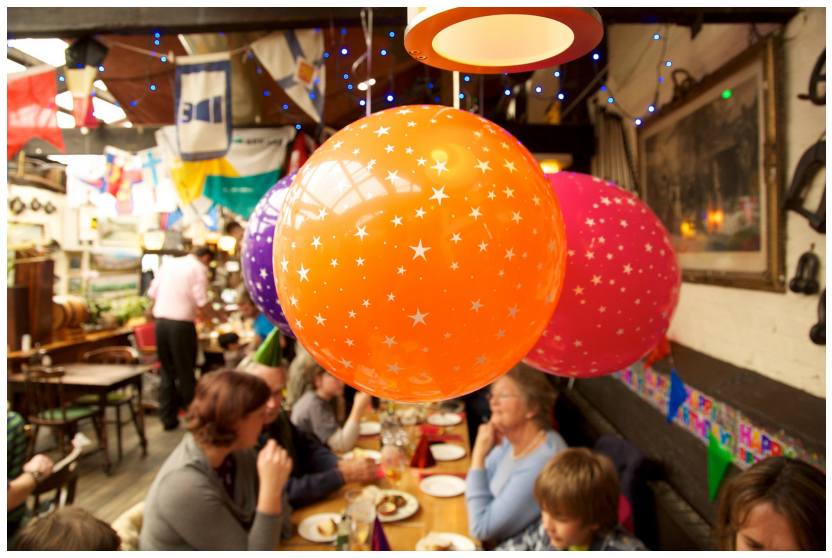

In [19]:
img_id = 23
img = dataset_train.load_image(img_id)
show_img(img)

In [20]:
mask, class_ids = dataset_train.load_mask(img_id)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


In [21]:
class_ids

array([1, 1, 1], dtype=int32)

In [22]:
mask, np.unique(mask, return_counts=True)

(array([[[False, False, False],
         [False, False, False],
         [False, False, False],
         ...,
         [False, False, False],
         [False, False, False],
         [False, False, False]],
 
        [[False, False, False],
         [False, False, False],
         [False, False, False],
         ...,
         [False, False, False],
         [False, False, False],
         [False, False, False]],
 
        [[False, False, False],
         [False, False, False],
         [False, False, False],
         ...,
         [False, False, False],
         [False, False, False],
         [False, False, False]],
 
        ...,
 
        [[False, False, False],
         [False, False, False],
         [False, False, False],
         ...,
         [False, False, False],
         [False, False, False],
         [False, False, False]],
 
        [[False, False, False],
         [False, False, False],
         [False, False, False],
         ...,
         [False, False, False],
       

In [23]:
dataset_train.class_names

['BG', 'balloon']

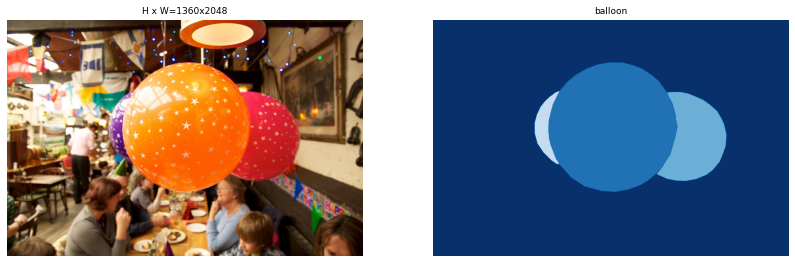

In [24]:
visualize.display_top_masks(img, mask, class_ids, dataset_train.class_names, 1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


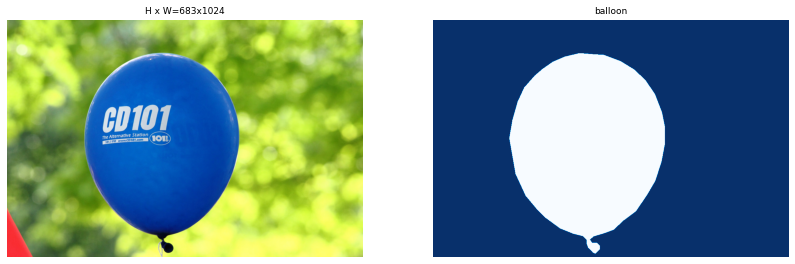

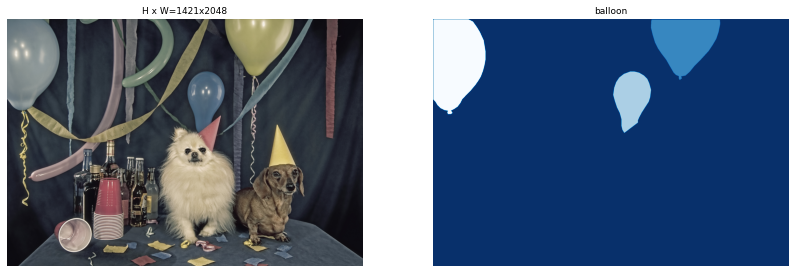

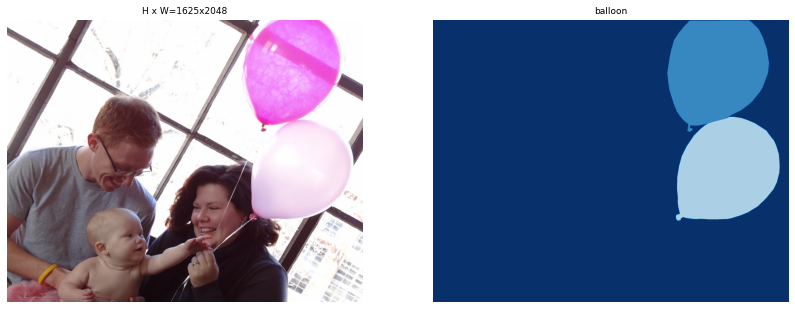

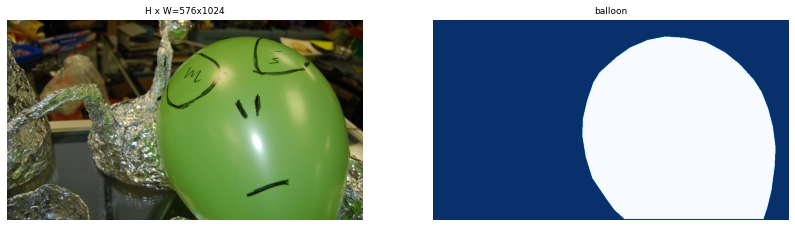

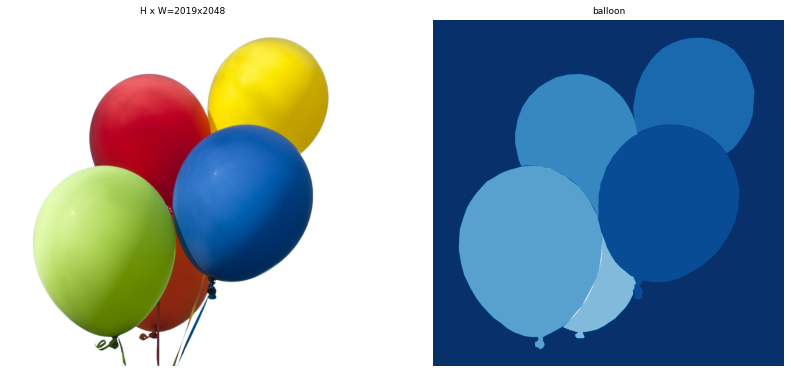

In [25]:
img_ids = np.random.choice(dataset_train.image_ids, 5)
for img_id in img_ids:
  img = dataset_train.load_image(img_id)
  mask, class_ids = dataset_train.load_mask(img_id)
  visualize.display_top_masks(img, mask, class_ids, dataset_train.class_names, 1)

In [26]:
img_id = 23
img = dataset_train.load_image(img_id)
mask, class_ids = dataset_train.load_mask(img_id)
bbox = utils.extract_bboxes(mask)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


In [27]:
bbox

array([[ 244,  664,  990, 1403],
       [ 415, 1287,  927, 1688],
       [ 409,  584,  831,  727]], dtype=int32)

In [28]:
print('Imagem', img_id, dataset_train.image_reference(img_id))
log('image', img)
log('mask', mask)
log('class_ids', class_ids)
log('bbox', bbox)

Imagem 23 /content/balloon/train/7178882742_f090f3ce56_k.jpg
image                    shape: (1360, 2048, 3)       min:    0.00000  max:  255.00000  uint8
mask                     shape: (1360, 2048, 3)       min:    0.00000  max:    1.00000  bool
class_ids                shape: (3,)                  min:    1.00000  max:    1.00000  int32
bbox                     shape: (3, 4)                min:  244.00000  max: 1688.00000  int32


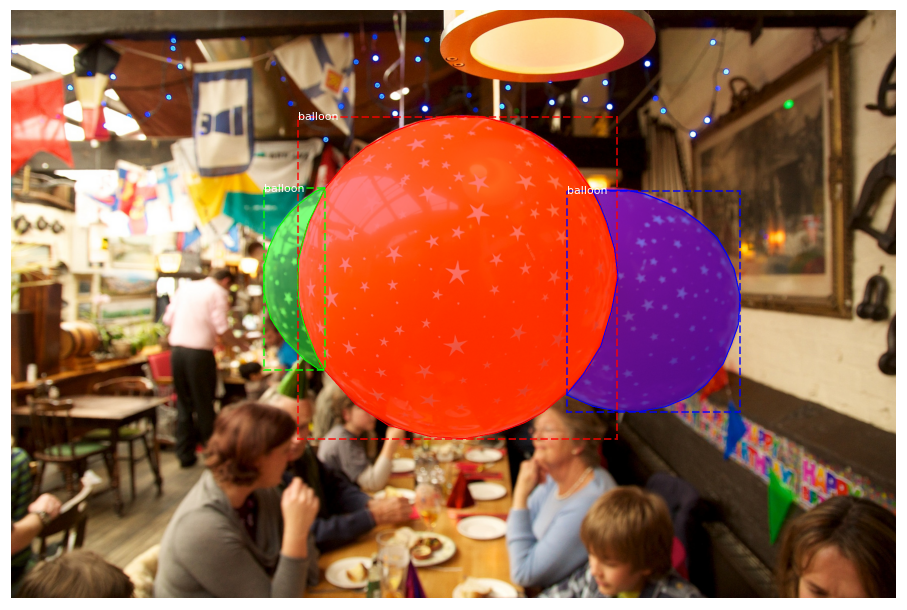

In [29]:
visualize.display_instances(img, bbox, mask, class_ids, dataset_train.class_names, show_bbox=True)

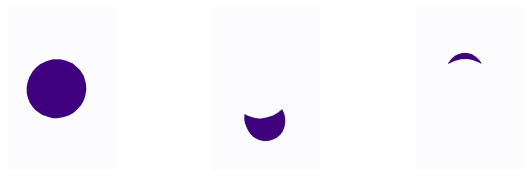

In [30]:
visualize.display_images(np.transpose(mask), cmap='Purples')

# Neural Network Settings

In [31]:
class ConfigNetwork(Config):
  NAME = 'balloon'
  IMAGES_PER_GPU = 2
  NUM_CLASSES = 1 + 1 # background plus class
  STEPS_PER_EPOCH = 100
  DETECTION_MIN_CONFIDENCE = 0.9
config = ConfigNetwork()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     2
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.9
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 2
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE         

In [32]:
models_path = os.path.join(root_path, 'logs')
models_path

'/content/Mask_RCNN/logs'

# Weight loading

In [33]:
# Transfer learning
path_modelo_COCO = os.path.join(root_path, 'mask_rcnn_coco.h5')
path_modelo_COCO

'/content/Mask_RCNN/mask_rcnn_coco.h5'

In [34]:
if not os.path.exists(path_modelo_COCO):
  utils.download_trained_weights(path_modelo_COCO)

... done downloading pretrained model!


In [35]:
def loading_training_model(settings, initial_model = 'coco', model_path=''):
  model = modellib.MaskRCNN(
      mode='training',
      config=settings,
      model_dir=model_path
  )
  if initial_model == 'coco':
    model.load_weights(
        path_modelo_COCO,
        by_name = True,
        exclude = ['mrcnn_class_logits', 'mrcnn_bbox_fc', 'mrcnn_bbox', 'mrcnn_mask']
  )
  elif initial_model == 'imagenet':
    model.load_weights(
        model.get_imagenet_weights(),
        by_name=True
  )
  elif initial_model == 'last':
    if model_path == "":
      model_path = model.find_last()
    model.load_weights(model_path, by_name=True)

  return model

In [ ]:
model = loading_training_model(config, 'coco')

NameError: ignored

# Training

In [36]:
!nvidia-smi

Tue Jul 12 00:52:23 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [37]:
start_time = time.time()
model.train(
    dataset_train,
    dataset_val,
    learning_rate = config.LEARNING_RATE,
    epochs = 25,
    layers='heads'
) # all
end_training = time.time()
minutes = round((end_training - start_time) / 60, 2)
print('\nTraining Time: ', minutes)

NameError: ignored

In [ ]:
model.find_last()

NameError: ignored

In [38]:
!cp /content/balloon20220707T0253/mask_rcnn_balloon_0001.h5 /content/gdrive/MyDrive/image-segmentation-course/modelos/mask_rcnn_balloon_0001.h5

cp: cannot stat '/content/balloon20220707T0253/mask_rcnn_balloon_0001.h5': No such file or directory


# Tests

## Neural Network settings to inference

In [39]:
class InferenceConfig(ConfigNetwork):
  GPU_COUNT = 1
  IMAGES_PER_GPU = 1
inference_config = InferenceConfig()

## Getting model stored model

In [40]:
!cp /content/gdrive/MyDrive/image-segmentation-course/modelos/mask_rcnn_balloon_0023.h5 /content/

## Neural Networking loading

In [41]:
def loading_test_model(model_path='ultimo'):
  inference_config = InferenceConfig()
  model = modellib.MaskRCNN(mode='inference', config=inference_config, model_dir=model_path)
  if model_path == 'ultimo':
    model_path = model.find_last()
  print('Getting model weights', model_path)
  model.load_weights(model_path, by_name=True)
  return model, inference_config

In [49]:
# First Option
#model_teste, inference_config = loading_test_model()

# Second Option
test_model, inference_config = loading_test_model('/content/mask_rcnn_balloon_0023.h5')

Getting model weights /content/mask_rcnn_balloon_0023.h5


## Test image segmentation

In [43]:
!cp -r /content/gdrive/MyDrive/image-segmentation-course/fotos /content/images/

In [44]:
dataset_val.class_names

['BG', 'balloon']

In [45]:
def segment_image(model_teste, img):
  results = model_teste.detect([img], verbose=0)
  regions = results[0]
  visualize.display_instances(
      img,
      regions['rois'],
      regions['masks'],
      regions['class_ids'],
      dataset_val.class_names,
      regions['scores'],
      figsize=(12,10)
  )
  return regions

In [46]:
from skimage.io import imread

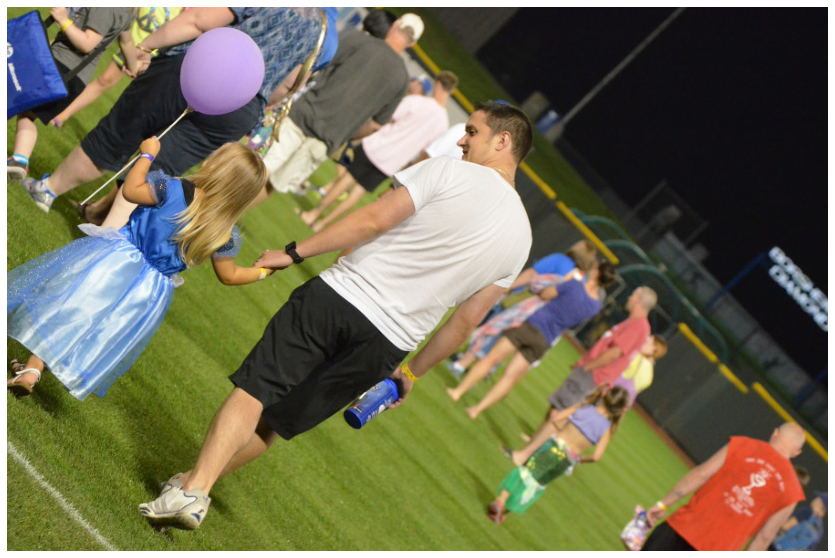

In [50]:
test_img = imread('images/baloes_teste01.jpg')
show_img(test_img)

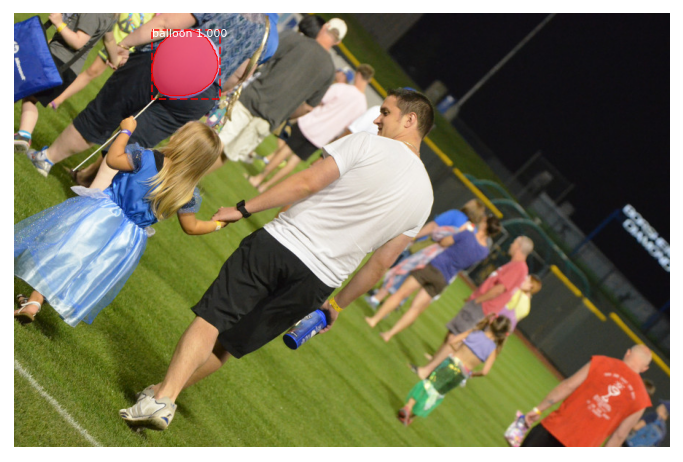

In [52]:
result_img = segment_image(test_model, test_img)

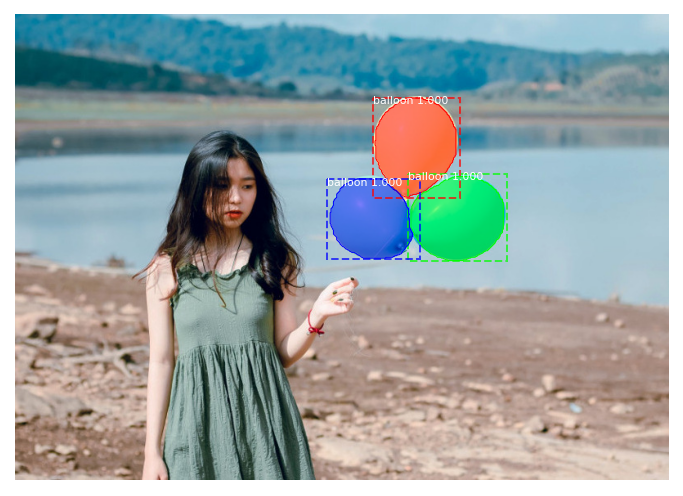

In [53]:
img_teste = imread("images/baloes_teste02.jpg")
result_img = segment_image(test_model, img_teste)

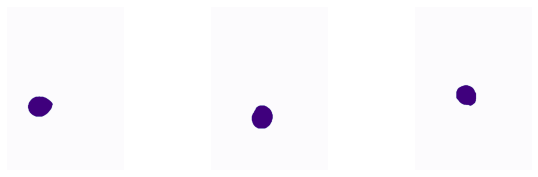

In [54]:
visualize.display_images(np.transpose(result_img['masks']), cmap="Purples")

## Segmenting Validation Images

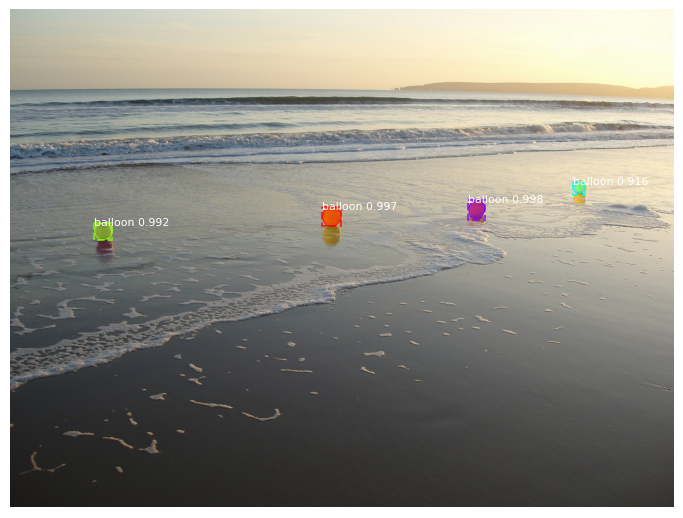

In [55]:
img_id = random.choice(dataset_val.image_ids) 
original_img = dataset_val.load_image(img_id) 
result_img = segment_image(test_model, original_img)

# Model Evaluation

In [56]:
# Evaluation metric: https://towardsdatascience.com/map-mean-average-precision-might-confuse-you-5956f1bfa9e2
APs = []
for img_id in dataset_val.image_ids:
  #print(img_id)
  img, img_meta, gt_class_id, gt_bbox, gt_mask = modellib.load_image_gt(dataset_val, inference_config, img_id, use_mini_mask=False)

  results = test_model.detect([img], verbose=0)
  result = results[0]

  AP, precisions, recalls, overlaps = utils.compute_ap(
      gt_bbox,
      gt_class_id,
      gt_mask,
      result['rois'],
      result['class_ids'],
      result['scores'],
      result['masks']
  )
  APs.append(AP)
  print(AP)
print('mAP: ', np.mean(APs))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


1.0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


0.7142857313156128


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


0.4444444477558136


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


0.6666666865348816


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


1.0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


0.821428582072258


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


1.0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


0.3333333432674408


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


1.0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


0.8333333134651184


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


1.0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


1.0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


1.0
mAP:  0.8318070849547019


In [58]:
def compare_validation(test_model, img_id, dataset_val, inference_config):
    
    img_original, img_meta, gt_class_id, gt_bbox, gt_mask = modellib.load_image_gt(
        dataset_val,
        inference_config,
        img_id,
        use_mini_mask=False
    )
        
    print("Trained model result vs. Ground-truth")

    # Trained model result
    results = test_model.detect([img_original], verbose=0)
    result = results[0]
    visualize.display_instances(
        img_original,
        result['rois'],
        result['masks'],
        result['class_ids'],
        dataset_val.class_names,
        result['scores'],
        figsize = (10,10)
    )
    
    # Ground-truth
    visualize.display_instances(
        img_original,
        gt_bbox,
        gt_mask,
        gt_class_id,
        dataset_val.class_names,
        figsize=(10, 10)
    )

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


Trained model result vs. Ground-truth


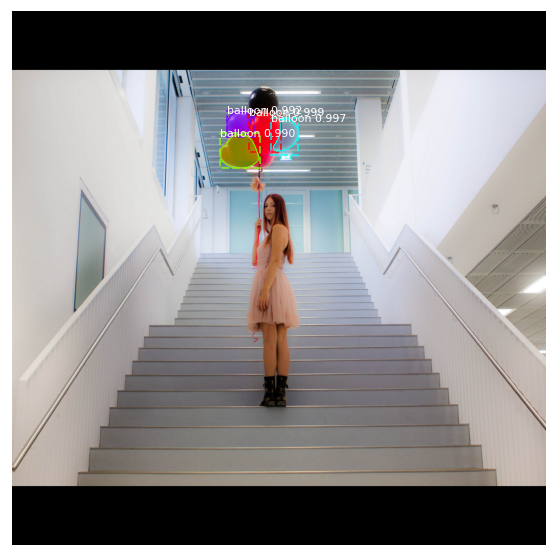

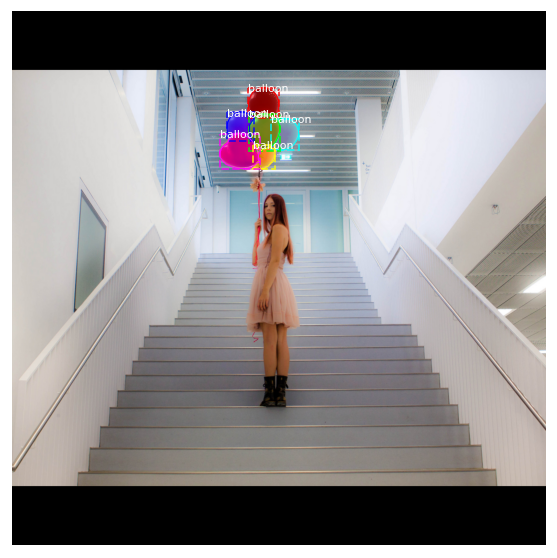

In [61]:
img_id = random.choice(dataset_val.image_ids)
compare_validation(test_model, img_id, dataset_val, inference_config)

# Cut Out Effect

In [62]:
def cutout_effect(img, mask):
    gray = skimage.color.gray2rgb(skimage.color.rgb2gray(img)) * 255
    # Copies the colors of the pixels of the original image, only for those that are inside the mask area
    if mask.shape[-1] > 0:
        mask = (np.sum(mask, -1, keepdims=True) >= 1)
        # Applies the effect to the mask area only
        splash = np.where(mask, img, gray).astype(np.uint8)
    else:
        splash = gray.astype(np.uint8)
    return splash

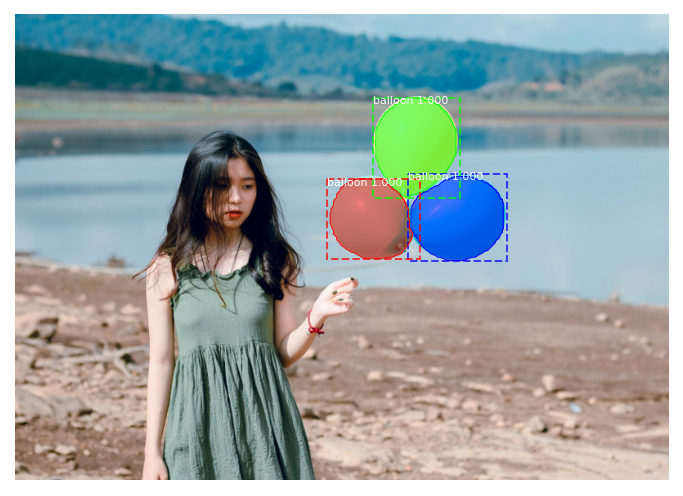

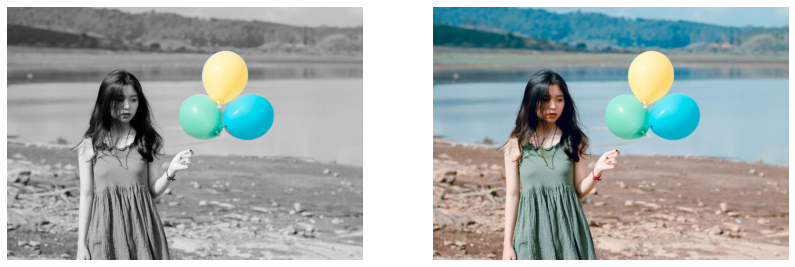

In [63]:
img_original = imread('images/baloes_teste02.jpg')
result = segment_image(test_model, img_original)
splash = cutout_effect(img_original, result['masks'])
visualize.display_images([splash, img_original], cols=2)